# Оценка эффективности
## 1 лабораторная работа - моделирование работы ПТУРа Milan против Т-80

В данной работе приводятся расчёты по моделированию функционирования ПТУРа против танка. В результате должны быть получены графики вероятностей попадания в различные точки танка с 3 углов (перед танка, бок и 45 градусов).


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
from scipy.stats import laplace, norm
import plotly.express as px
from matplotlib import pyplot, transforms
from matplotlib.patches import Circle, PathPatch, Rectangle
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib as mpl


1. Рассчитаем дельту отклонения

In [10]:
def extrapolation_(r, q = [[ 200, 50 ], [800, 400 ]],):
    result = (q[0][1] + (r - q[0][0]) /
        (q[1][0] - q[0][0]) *
        (q[1][1] - q[0][1]));
 
    return result

In [11]:
x_array = np.arange(200, 6000)
dataset = [[ 200, 50 ], [800, 400 ]]
y_array = extrapolation_(x_array, dataset)


Text(0.5, 0, 'Дальность, м')

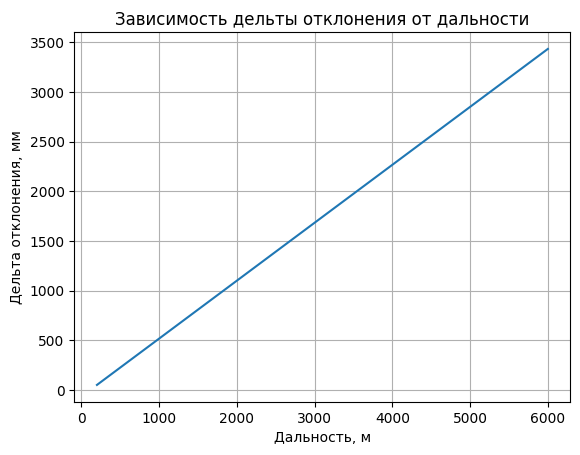

In [12]:
plt.plot(x_array, y_array)
plt.grid()
plt.title("Зависимость дельты отклонения от дальности")
plt.ylabel("Дельта отклонения, мм")
plt.xlabel("Дальность, м")

2. Броня танка

In [13]:
missile_penetration = 350

In [14]:
def f_laplace(x):
    return norm.cdf(x) - 0.5

In [15]:
def make_rect(x, y, width, height, thickness, color, ax, armors, alpha=0.5, rotate=0):
    color = 'green' if missile_penetration > thickness else 'red'
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor=color, alpha=alpha)
    
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/2.0
    
    
    if rotate != 0:
        t2 = mpl.transforms.Affine2D().rotate_deg_around(cx, cy, rotate) + ax.transData
        rect.set_transform(t2)
        
    
    
    
    ax.add_patch(rect)
    ax.annotate(f'{thickness}', (cx, cy), color='white', weight='bold', fontsize=10, ha='center', va='center')
    
    
    
    hit = 1 if color == 'green' else 0
    armors.append({"x_bottom": x, "y_bottom": y, "x_top": x+width, "y_top": y+height, "hit": hit, "thickness": thickness})

In [16]:
def tank_dots(x, y):
    
    tank_front_dots_x = np.arange(0, x, 100)
    tank_front_dots_y = np.arange(0, y, 100)

    x_array_dots = []
    y_array_dots = []

    for x_dot in tank_front_dots_x:
        for y_dot in tank_front_dots_y:
            x_array_dots.append(x_dot)
            y_array_dots.append(y_dot)
    
    return [x_array_dots, y_array_dots]
        
        

In [17]:
def penetration_probability(armors):
    dict = {'thickness': [], 'probability': []}
    for armor in armors:
        dict['thickness'].append(armor['thickness'])
        if armor['thickness'] < (missile_penetration * 0.9):
                penetration_probability = 1
        elif armor['thickness'] > (missile_penetration * 0.9) and armor['thickness'] < (missile_penetration * 1.1):
            penetration_probability = 1 - ( (armor['thickness'] - (missile_penetration * 0.9)) / 60 )
        else:
            penetration_probability = 0
        dict['probability'].append(penetration_probability)
        
    df = pd.DataFrame(data=dict)
    print(df)
    

In [18]:
def compute_probability(x_dots, y_dots, armors_array, sqo):
    pos = np.array([])
    
    for i in range(len(x_dots)):
        dot_probabilities = []
        for armor in armors_array:
            hit_probability_x = (f_laplace( (armor['x_top'] - x_dots[i])/sqo ) - f_laplace( (armor['x_bottom'] - x_dots[i]) / sqo ))
            hit_probability_y = (f_laplace( (armor['y_top'] - y_dots[i])/sqo ) - f_laplace( (armor['y_bottom'] - y_dots[i]) / sqo ))
            hit_probability = hit_probability_x * hit_probability_y
            
            if armor['thickness'] < (missile_penetration * 0.9):
                penetration_probability = 1
            elif armor['thickness'] > (missile_penetration * 0.9) and armor['thickness'] < (missile_penetration * 1.1):
                penetration_probability = 1 - ( (armor['thickness'] - (missile_penetration * 0.9)) / 60 )
            else:
                penetration_probability = 0

            probability = hit_probability * penetration_probability
            dot_probabilities.append(probability)
        pos = np.append(pos, np.sum(dot_probabilities))
    return pos

2.1 Лобовая броня танка

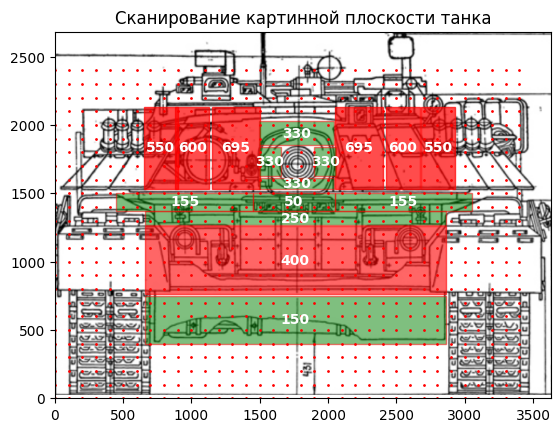

In [19]:
img = plt.imread("tank_pered.png")
fig, ax = plt.subplots()
x = range(300)
ax.imshow(img, extent=[0, 3630, 0, 2682])

front_armors = []

# Корпус

make_rect(660, 400, 2200, 350, 150, 'green', ax, front_armors)
make_rect(660, 760, 2200, 500, 400, 'red', ax, front_armors, 0.6)
make_rect(660, 1265, 2200, 105, 250, 'red', ax, front_armors)

make_rect(450, 1370, 1000, 135, 155, 'red', ax, front_armors)
make_rect(2050, 1370, 1000, 135, 155, 'red', ax, front_armors)

make_rect(1450, 1370, 600, 135, 50, 'red', ax, front_armors)

# Башня

make_rect(1150, 1535, 350, 600, 695, 'red', ax, front_armors, 0.7)
make_rect(880, 1535, 250, 600, 600, 'red', ax, front_armors, 0.7)
make_rect(650, 1535, 250, 600, 550, 'red', ax, front_armors, 0.7)


make_rect(2050, 1535, 350, 600, 695, 'red', ax, front_armors, 0.7)
make_rect(2420, 1535, 250, 600, 600, 'red', ax, front_armors, 0.7)
make_rect(2680, 1535, 250, 600, 550, 'red', ax, front_armors, 0.7)

# Маска орудия

make_rect(1495, 1535, 550, 80, 330, 'green', ax, front_armors)
make_rect(1495, 1850, 550, 180, 330, 'green', ax, front_armors)

make_rect(1495, 1630, 160, 210, 330, 'green', ax, front_armors)
make_rect(1900, 1630, 160, 210, 330, 'green', ax, front_armors)

# Сканирование

[x_dots, y_dots] = tank_dots(3500, 2500)

ax.scatter(x_dots, y_dots, s=1, color='red')
ax.set_title('Сканирование картинной плоскости танка')

plt.show()

In [20]:
front_armors

def armor_table(armors):
    df = pd.DataFrame(data={'x_bot': [], 'x_top': [], 'y_bot': [], 'y_top': [], 'Толщина': []})
    for i in range(len(armors)):
        df.loc[i] = [int(armors[i]['x_bottom']), 
                     int(armors[i]['x_top']), 
                     int(armors[i]['y_bottom']),
                     int(armors[i]['x_top']),
                     int(armors[i]['thickness'])]
    return df
    
armor_table(front_armors)

,x_bot,x_top,y_bot,y_top,Толщина
0,660,2860,400,2860,150
1,660,2860,760,2860,400
2,660,2860,1265,2860,250
3,450,1450,1370,1450,155
4,2050,3050,1370,3050,155
5,1450,2050,1370,2050,50
6,1150,1500,1535,1500,695
7,880,1130,1535,1130,600
8,650,900,1535,900,550
9,2050,2400,1535,2400,695


In [21]:
first_armor_table = armor_table(front_armors)
first_armor_table.to_excel('armor_table.xlsx')

In [22]:
penetration_probability(front_armors)

    thickness  probability
0         150         1.00
1         400         0.00
2         250         1.00
3         155         1.00
4         155         1.00
5          50         1.00
6         695         0.00
7         600         0.00
8         550         0.00
9         695         0.00
10        600         0.00
11        550         0.00
12        330         0.75
13        330         0.75
14        330         0.75
15        330         0.75


In [40]:
def plot_probability(x, y, z, distance, x_angle = 30, y_angle=-45):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    X = x
    Y = y
    Z = z

    surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none')

    plt.colorbar(surf)
    plt.subplots_adjust(right=2)

    ax.set_title(f'Вероятность поражения танка на дистанции {distance} м')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('P')
    
#     ax.set_zticks(np.arange(0, 0.9, 0.1))

    ax.view_init(x_angle, y_angle)

    plt.show()

In [24]:
distance = 700
standard_deviation = extrapolation_(distance)
front_hit = compute_probability(x_dots, y_dots, front_armors, standard_deviation)  


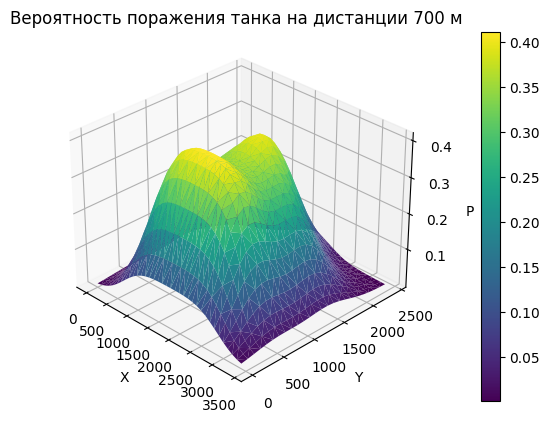

In [41]:
plot_probability(x_dots, y_dots, front_hit, distance)

Text(0.5, 0, 'X')

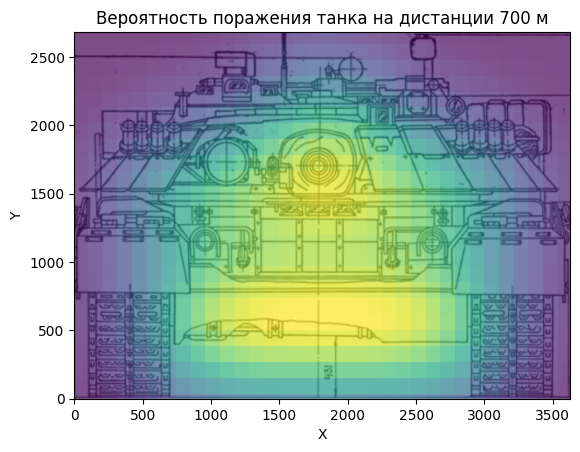

In [26]:

s = np.array(front_hit).reshape(35, 25)

base = ax.transData
rot = mtransforms.Affine2D().scale(0.8, 1.4).translate(-200, -3600).rotate_deg(90)



img = plt.imread("pered.png")
fig, ax = plt.subplots()
img1 = ax.imshow(img, extent=[0, 3630, 0, 2682])
img2 = ax.imshow(s, cmap='viridis', alpha=0.7, extent=[0, 3630, 0, 2682])

img2.set_transform(rot + base)

ax.set_title(f'Вероятность поражения танка на дистанции {distance} м')
ax.set_ylabel('Y')
ax.set_xlabel('X')




In [27]:
data = {
    'x': x_dots,
    'y': y_dots,
    'hit_p': front_hit
}
df = pd.DataFrame(data)
df

,x,y,hit_p
0,0,0,0.002855
1,0,100,0.004323
2,0,200,0.006057
3,0,300,0.007870
4,0,400,0.009515
...,...,...,...
870,3400,2000,0.007262
871,3400,2100,0.004270
872,3400,2200,0.002311
873,3400,2300,0.001151


2.2 Боковая броня танка

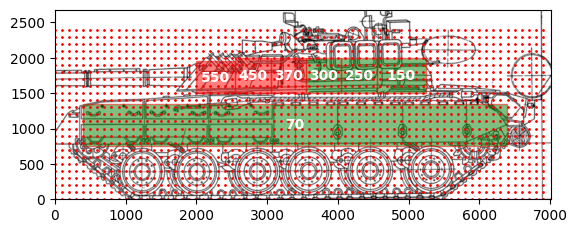

In [29]:
img = plt.imread("t-80-side.png")
fig, ax = plt.subplots()
x = range(300)
ax.imshow(img, extent=[0, 7012, 0, 2682])

side_armors = []


# Корпус
make_rect(395, 750, 6000, 600, 70, 'green', ax, side_armors)

# Башня
make_rect(2000, 1500, 550, 450, 550, 'red', ax, side_armors)
make_rect(2550, 1500, 500, 500, 450, 'red', ax, side_armors)
make_rect(3050, 1500, 500, 500, 370, 'green', ax, side_armors)
make_rect(3550, 1500, 500, 500, 300, 'green', ax, side_armors)
make_rect(4050, 1500, 500, 500, 250, 'green', ax, side_armors)
make_rect(4550, 1500, 700, 500, 150, 'green', ax, side_armors)

# Сканирование

[x_side_dots, y_side_dots] = tank_dots(7000, 2500)
ax.scatter(x_side_dots, y_side_dots, s=1, color='red')

plt.show()



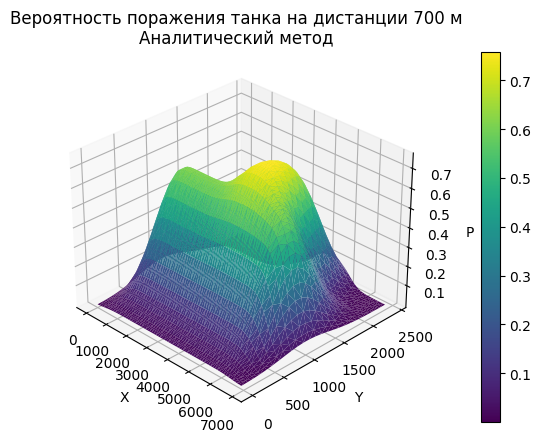

In [30]:
side_hit = compute_probability(x_side_dots, y_side_dots, side_armors, standard_deviation)
plot_probability(x_side_dots, y_side_dots, side_hit, distance)


In [31]:
# table_side_armor = armor_table(side_armors)
# table_side_armor.to_excel('armor_table.xlsx')

Text(0.5, 0, 'X')

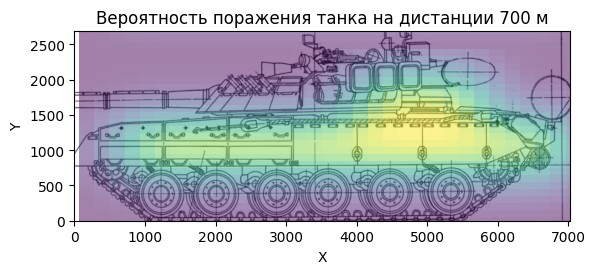

In [33]:
len(x_side_dots)
s = np.array(side_hit).reshape(35, 50)

base = ax.transData
rot = mtransforms.Affine2D().scale(0.7, 2.8).translate(-1300, -7500).rotate_deg(90)



img = plt.imread("t-80-side.png")
fig, ax = plt.subplots()
img1 = ax.imshow(img, extent=[0, 7030, 0, 2682])
img2 = ax.imshow(s, cmap='viridis', alpha=0.5, extent=[0, 7030, 0, 2682])

img2.set_transform(rot + base)

ax.set_title(f'Вероятность поражения танка на дистанции {distance} м')
ax.set_ylabel('Y')
ax.set_xlabel('X')


